František Šefčík a Vajk Pomichal, IAU, zimný semester 2018
# Projekt 1

#### Dataset 31

## Preprocessing

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression


In [129]:
pd.options.display.max_columns = None

In [130]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')

### 1. Integracia dat a prípadna deduplikacia zaznamov

Na zaklade prieskumnej analyzy sme zistili ze kombinaciou 'name' a 'address' atributov dostaneme unikatny identifikator, na zaklade coho dokazeme spojit datasety.

In [131]:
result_train = pd.merge(personal_train, other_train, on=['name', 'address'])
result_test = pd.merge(personal_valid, other_valid, on=['name', 'address'])

In [132]:
result_train



,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
0,0,Edith Boudreaux,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,F,69-04-28,1425,f,t,HS-grad,f,103.0,1.11,0.0,0.0,f,8.300,0.9,108997.0,40.0,Unmarried,f,Private,t,Negative.|1379,Divorced,f,United-States,f,"{'query hypothyroid':'t','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,White,93
1,1,Janet Washington,"PSC 4657, Box 5446\nAPO AP 58412",78.0,F,1940-01-23,458,f,t,Some-college,f,112.0,0.82,0.0,0.0,f,3.100,1.1,424012.0,40.0,Not-in-family,f,Federal-gov,t,negative.|954,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVHD,10.0,Exec-managerial,f,?,White,137
2,2,Margaret Chabot,Unit 9759 Box 9470\nDPO AP 45549,65.0,F,1953-06-23,1875,f,t,Masters,f,113.0,0.85,0.0,0.0,f,0.035,NaN,143046.0,40.0,Not-in-family,f,Private,t,negative.|3301,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,133
3,3,Terry Terry,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,M,1984-03-08,56,t,t,Bachelors,f,99.0,0.87,0.0,0.0,f,0.080,2.1,183390.0,40.0,Not-in-family,f,Local-gov,t,Negative.|3756,Separated,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Prof-specialty,f,?,White,113
4,4,Stephen Lalk,"995 Frank Stravenue\nSouth Matthewport, TX 81402",57.0,M,1961-09-16,599,f,t,Bachelors,f,164.0,1.14,0.0,0.0,f,1.600,2.1,106935.0,45.0,Husband,f,Private,t,negative.|2198,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",F,SVI,13.0,Exec-managerial,f,?,White,145
5,5,Colleen Satterwhite,"1781 Meredith Skyway Suite 328\nCordovaburgh, ...",59.0,F,1959-08-05,543,f,t,HS-grad,f,121.0,1.11,1721.0,0.0,f,1.400,1.1,91939.0,30.0,Not-in-family,f,Private,t,negative.|2283,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,Black,109
6,6,Abraham Bruce,"2415 Elizabeth Knoll Suite 030\nCordovafort, C...",53.0,M,1965-10-10,2168,f,t,Doctorate,f,127.0,0.90,0.0,0.0,f,0.080,NaN,214627.0,60.0,Husband,f,Self-emp-inc,t,negative.|3276,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,16.0,Prof-specialty,f,?,White,141
7,7,James Wilson,"49824 Kim View\nWest Ericborough, VT 42457",46.0,M,1972-09-07 00 00 00,617,f,t,Some-college,f,98.0,0.94,0.0,0.0,f,0.600,NaN,183532.0,25.0,Own-child,f,Private,t,negative.|3604,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Handlers-cleaners,f,?,White,104
8,8,Judy Smith,"53231 Matthew Spur Apt. 079\nNorth Brian, MA 3...",25.0,F,1992-12-27,851,f,t,HS-grad,f,85.0,0.79,0.0,0.0,f,0.020,2.3,137310.0,40.0,Own_child,f,Private,t,negative.|2779,Never-married,f,?,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,9.0,Machine-op-inspct,f,?,White,107
9,9,Anna Swartz,USNV Gallegos\nFPO AA 99743,33.0,F,1985-09-05 00:00:00,57,f,t,Assoc-voc,f,NaN,0.90,0.0,0.0,f,8.200,1.5,222216.0,38.0,Unmarried,f,?,t,negative.|1117,Widowed,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,STMW,11.0,?,f,?,White,83


In [133]:
print("pred personal train (riadky,stlpce): ",personal_train.shape)
print("pred other train (riadky,stlpce): ",other_train.shape)
print("vysledny train (riadky,stlpce): ",result_train.shape)

pred personal train (riadky,stlpce):  (2237, 6)
pred other train (riadky,stlpce):  (2287, 34)
vysledny train (riadky,stlpce):  (2287, 38)


In [134]:
print("chybajuce hodnoty name: ",result_train.name.isna().sum())
print("chybajuce hodnoty address: ",result_train.address.isna().sum())
print("chybajuce hodnoty age: ",result_train.age.isna().sum())
print("chybajuce hodnoty sex: ",result_train.sex.isna().sum())

chybajuce hodnoty name:  0
chybajuce hodnoty address:  0
chybajuce hodnoty age:  1
chybajuce hodnoty sex:  0


Spojili sme dva df kde vysledny počet stlpcov sa rovná množine jedinečnych atributov z oboch datasetov. A uspešne sa namapovali všetky riadky z personal_train na riadky other_train, takze vysledny pocet riadkov sa rovna poctu riadkov v other_train a zaroven sa nestratili ziadne informacie.

Musime sa pozriet este na duplikatne zaznamy.

In [135]:
result_train.name.value_counts()

Renee Henderson        3
Terry Murphy           2
Carol Parton           2
Courtney Mckinnon      2
Elizabeth Hoyman       2
Betty Keith            2
Gary Gallman           2
Gerald Sanford         2
Nicole Kitchens        2
Alan Holman            2
Vera Steinert          2
Eula Stoller           2
Dorothy Sheets         2
Pamela Bridges         2
Pauline Linden         2
Joseph Thurston        2
Bill Lowrey            2
Zachary Grant          2
Marta Scott            2
Jimmie Tanner          2
Marian West            2
James Butterfield      2
Melvin Merriweather    2
Kathy Burroughs        2
Jodi Hodges            2
Stephanie Darden       2
Monica Carter          2
Amanda Henrie          2
Denise Clark           2
Connie Alley           2
                      ..
Donna Flory            1
Michelle Kirgan        1
Judy Smith             1
Ann Cox                1
Sophie Vorhies         1
Stephen Payne          1
Billy Mason            1
Sharon Weiskopf        1
Linda Matson           1


In [136]:
result_train[result_train['name'] == 'Aimee Elliott']

,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
1978,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,184,f,t,HS-grad,f,??,0.97,0.0,NaN,f,0.25,NaN,799281.0,38.0,Unmarried,NaN,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,114
1979,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,195,f,t,HS-grad,f,??,0.97,0.0,0.0,f,0.25,2.5,799281.0,38.0,Unmarried,f,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",NaN,NaN,9.0,Adm-clerical,f,?,White,114


Ked sme sa pozreli na zaznamy kde sa mena opakuju, zistili sme ze hodnoty v zaznamoch su rovnake, rozdiel je len, ze niektore stlpce obsahuju Nan hodnotu pre jeden zaznam, a pre duplikat nie alebo opacne. Potrebujeme z tychto duplikatov vytvorit jeden zaznam ktory bude obsahovat zjednotenie ich neprazdnych hodnot.

In [137]:
def func(vstup):
    return reduce(lambda x,y: x if not pd.isna(x) else y, vstup)


def deduplicate(df,columns = []):
    df_copy = df.copy()
    
    deduplicated = df_copy[df_copy.duplicated(subset=columns, keep=False)].groupby(columns).agg(func).reset_index()
    
    df_copy.drop_duplicates(subset=columns, keep=False, inplace=True)
    
    return pd.concat([df_copy,deduplicated], sort = True).reset_index(drop=True)
    

In [138]:
result_test = deduplicate(result_test,columns = ['name','address'])
print(result_test.shape)
print(personal_valid.shape)

(972, 38)
(972, 6)


Pocet zaznamov sme znizili na pocet zaznamov v tabulke personal info, co indikuje dobry postup riesenia, detailnejsie sa pozrieme na trenovacie data:

In [139]:
result_train = deduplicate(result_train,columns = ['name','address'])
print(result_train.shape)
print(personal_train.shape)

(2237, 38)
(2237, 6)


In [140]:
result_train.name.value_counts()

Terry Murphy            2
Dayna King              1
Rosemarie Heskett       1
Mark Barr               1
Anthony Bryant          1
Linda Branscomb         1
Ann Hensley             1
Jennifer Luna           1
Trisha Harding          1
Angelica Dowd           1
Jayne Warren            1
Dorothy Bass            1
Dawne Cousins           1
Philip Willis           1
James Hart              1
Donna Lawrence          1
Carol Crum              1
Steven Smith            1
Eleanor Souliere        1
Francine Newman         1
Lisa Sizer              1
Roxanne Gray            1
Julia Smith             1
Gregory Oldfield        1
Zella Perrins           1
Carroll Stallard        1
Jill Hayes              1
Vera Wolfe              1
Robert Lamm             1
Jennifer Fitzpatrick    1
                       ..
David Cook              1
Nancy Lardizabal        1
Sharon Paik             1
Natasha Dishman         1
Charlotte Vasquez       1
Gloria Merritt          1
Heather Hernandez       1
Sue Messner 

In [141]:
result_train[result_train.name == 'Terry Murphy']

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass
616,78,t,2.5,1.11,?,f,3.9,87.0,t,633,1063,806 Oconnell Light Suite 551\nNorth Aprilborou...,72.0,0.0,0.0,negative.|2600,1946-06-06,Some-college,10.0,250819.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,United-States,Adm-clerical,f,f,White,SVI,Not_in_family,F,f,f,Private
1005,92,t,NaN,0.95,?,f,5.2,88.0,t,1032,1986,"763 Figueroa Divide\nZimmermanland, WA 65355",60.0,0.0,0.0,Negative.|3479,1958-08-19,HS-grad,9.0,205100.0,f,38.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,Germany,Prof-specialty,f,f,White,SVI,Husband,M,f,f,Self-emp-inc


Ziskali sme unikatne zaznamy pre kazdu osobu, vidime ze vsetky osoby v datach maju unikatne meno az na jeden objekt, ktori sice ma totozne meno s inym zaznamom, ale mozme vidiet ze sa jedna o uplne ineho pacienta.  

Pocet vsetkych zaznamov sa rovna aj poctu zaznamov v tabulke personal_train, co aj potvrdzuje nase vysledky.

In [142]:
result_train = result_train.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1)

### 2. Predspracovanie 

#### Extrahovanie atributov zo stlpca "medical_info"

In [143]:
class Extraction(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for index,row in enumerate(df_copy[self.column]):
            if not pd.isna(row):
                d = json.loads(row.replace("'", "\""))
                for key,val in d.items():
                    df_copy.loc[index,key] = val
            
        return df_copy

#### Oprava stlpcov s true, false hodnotami a obmedzenie hodnot v stlcpi class na 'negative, 'increased', 'decreased'


In [144]:
class StringReplacer(TransformerMixin):
    def __init__(self,columns, source, target):
        self.columns = columns
        self.source = source
        self.target = target
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            sample = df_copy[col].str.contains(self.source, na=False, regex=False, case=False)
            df_copy.loc[sample, col] = self.target
        return df_copy

#### Zmena typu stlcov z object na cislo

In [145]:
class ObjectToNumeric(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            df_copy['TT4'] = pd.to_numeric(df_copy[col], errors='coerce')
        return df_copy

#### 2.1 Vychylene hodnoty

#### Nahradanie extremnych hodnot

In [146]:
class ReplaceOutliersWithPercentile(TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name

    def fit(self, df, y=None, **fit_params):
        Q1 = df[self.col_name].quantile(0.25)
        Q3 = df[self.col_name].quantile(0.75)
        IQR = Q3 - Q1
        self.min_replace = df[self.col_name].quantile(0.05)
        self.max_replace = df[self.col_name].quantile(0.95)
        self.min_extreme = (Q1 - 1.5 * IQR)
        self.max_extreme = (Q3 + 1.5 * IQR)                   
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        extremes_min = df_copy[df_copy[self.col_name] < self.min_extreme].index
        extremes_max = df_copy[df_copy[self.col_name] > self.max_extreme].index
        df_copy.loc[extremes_min, self.col_name] = self.min_replace
        df_copy.loc[extremes_max, self.col_name] = self.max_replace
        return df_copy

#### Odstranenie extremnych hodnot

In [175]:
class DropOutliers(TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name

    def fit(self, df, y=None, **fit_params):
        Q1 = df[self.col_name].quantile(0.25)
        Q3 = df[self.col_name].quantile(0.75)
        IQR = Q3 - Q1
        self.min_extreme = (Q1 - 1.5 * IQR)
        self.max_extreme = (Q3 + 1.5 * IQR)                   
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        extremes_min = df_copy[df_copy[self.col_name] < self.min_extreme].index
        extremes_max = df_copy[df_copy[self.col_name] > self.max_extreme].index
        df_copy.drop(extremes_min, inplace=True)
        df_copy.drop(extremes_max, inplace=True)
        return df_copy

#### BoxCox normalizacia hodnot

In [148]:
class BoxCoxNormalization(TransformerMixin):
    def __init__(self, col_name, new_name=""):
        self.col_name = col_name
        self.new_name = new_name if new_name != "" else col_name

    def fit(self, df, y=None, **fit_params):
        _, self.boxcox_attr = boxcox(df[self.col_name])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        transformed = boxcox(df_copy[self.col_name], lmbda=self.boxcox_attr)
        df_copy[self.new_name] = transformed
        return df_copy

#### 2.2 Chybajuce hodnoty

#### Nahradenie chybajucich hodnot medianom alebo priemerom 

In [149]:
class ReplaceNans(TransformerMixin):
    def __init__(self, col_name, func_type = 'median'):
        self.col_name = col_name
        self.func_type = func_type

    def fit(self, df, y=None, **fit_params):
        if(self.func_type == 'median'):
            self.na_replace = df[self.col_name].median()
        else:
            self.na_replace = df[self.col_name].mean()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.col_name] = df_copy[self.col_name].fillna(self.na_replace)
        return df_copy

In [150]:
class ReplaceNanWithModel(TransformerMixin):
    def __init__(self, col_name, model):
        self.col_name = col_name
        self.model = model

    def fit(self, df, y=None, **fit_params):
        
        newdf = self.selectColumns(df)
        newdf = newdf.dropna()
        self.model.fit(newdf[newdf.columns.difference([self.col_name])],newdf[self.col_name])
         
        return self

    def transform(self, df, **transform_params):
        
        # ziskanie vsetkych riadkov ktore chceme predikovat
        newdf = df[df[self.col_name].isna()]
        # ziskanie len numerickych atributov
        newdf = self.selectColumns(newdf)
        # odstranenie vsetkych riadkov kde su nejake nan hodnoty okrem atributu ktory predikujeme
        newdf = newdf[newdf.columns.difference([self.col_name])].dropna()
               
        prediction = self.model.predict(newdf)
        
        return prediction
    
    def selectColumns(self,df):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        return df.select_dtypes(include=numerics)
        
        

In [151]:
mojTransform = ReplaceNanWithModel('TSH',LinearRegression())
mojTransform.fit(result_train)
hah = mojTransform.transform(result_train)


In [152]:
other_train['TSH'].isna().value_counts()


False    2041
True      246
Name: TSH, dtype: int64

In [153]:
result_train['T3'].median()

2.0

### 3. Opatovna prieskumna analyza

Ako prve vytiahneme informacie zo stlpca medical_info, opravime hodnoty True/False, hodnoty v stlci class obmedzime na tri hodnoty (negative, increased, decreased) a zmenime typ stlpca TT4 z object na cislo

In [154]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

ppl = Pipeline([
     ('ExtraxtMedicalInfo',Extraction('medical_info')),
     ('ReplaceFalseCorrect',StringReplacer(true_false_cols,'f','f')),
     ('ReplaceTrueCorrect',StringReplacer(true_false_cols,'t','t')),
    ('ReplaceClassNegative',StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',StringReplacer(['class'],'decrease','decreased')),
    ('TT4toNUmeric', ObjectToNumeric(['TT4']))
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)

In [155]:
X_train

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass,psych,T3 measured,thyroid surgery,I131 treatment,TSH measured,query hypothyroid,T4U measured,on thyroxine,pregnant,query on thyroxine
0,93,t,0.9,1.11,?,f,8.300,103.0,t,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,0.0,0.0,negative,69-04-28,HS-grad,9.0,108997.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'t','T4U measured':'t','p...",Edith Boudreaux,United-States,Adm-clerical,f,f,White,SVI,Unmarried,F,f,f,Private,f,t,f,f,t,t,t,f,f,f
1,137,t,1.1,0.82,?,f,3.100,112.0,t,"PSC 4657, Box 5446\nAPO AP 58412",78.0,0.0,0.0,negative,1940-01-23,Some-college,10.0,424012.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",Janet Washington,United-States,Exec-managerial,f,f,White,SVHD,Not-in-family,F,f,f,Federal-gov,f,t,f,f,t,f,t,f,f,f
2,133,t,NaN,0.85,?,f,0.035,113.0,t,Unit 9759 Box 9470\nDPO AP 45549,65.0,0.0,0.0,negative,1953-06-23,Masters,NaN,143046.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Margaret Chabot,United-States,Adm-clerical,f,f,White,other,Not-in-family,F,f,f,Private,f,f,f,f,t,f,t,f,f,f
3,113,t,2.1,0.87,?,f,0.080,99.0,t,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,0.0,0.0,negative,1984-03-08,Bachelors,NaN,183390.0,f,40.0,f,f,Separated,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Terry,United-States,Prof-specialty,f,t,White,other,Not-in-family,M,f,f,Local-gov,f,t,f,f,t,f,t,f,f,f
4,145,t,2.1,1.14,?,f,1.600,164.0,t,"995 Frank Stravenue\nSouth Matthewport, TX 81402",57.0,0.0,0.0,negative,1961-09-16,Bachelors,13.0,106935.0,f,45.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Stephen Lalk,United-States,Exec-managerial,f,f,White,SVI,Husband,M,f,f,Private,f,t,f,f,t,f,t,f,f,f
5,109,t,1.1,1.11,?,f,1.400,121.0,t,"1781 Meredith Skyway Suite 328\nCordovaburgh, ...",59.0,0.0,1721.0,negative,1959-08-05,HS-grad,9.0,91939.0,f,30.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Colleen Satterwhite,United-States,Adm-clerical,f,f,Black,SVI,Not-in-family,F,f,f,Private,f,t,f,f,t,f,t,f,f,f
6,141,t,NaN,0.90,?,f,0.080,127.0,t,"2415 Elizabeth Knoll Suite 030\nCordovafort, C...",53.0,0.0,0.0,negative,1965-10-10,Doctorate,16.0,214627.0,f,60.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Abraham Bruce,United-States,Prof-specialty,f,f,White,other,Husband,M,f,f,Self-emp-inc,f,f,t,f,t,f,t,t,f,f
7,104,t,NaN,0.94,?,f,0.600,98.0,t,"49824 Kim View\nWest Ericborough, VT 42457",46.0,0.0,0.0,negative,1972-09-07 00 00 00,Some-college,NaN,183532.0,f,25.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",James Wilson,United-States,Handlers-cleaners,f,f,White,other,Own-child,M,f,f,Private,f,f,f,f,t,f,t,f,f,f
8,107,t,2.3,0.79,?,f,0.020,85.0,t,"53231 Matthew Spur Apt. 079\nNorth Brian, MA 3...",25.0,0.0,0.0,negative,1992-12-27,HS-grad,9.0,137310.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Judy Smith,?,Machine-op-inspct,f,f,White,other,Own_child,F,f,f,Private,f,t,f,f,t,f,t,f,f,f
9,83,t,1.5,0.90,?,f,8.200,NaN,t,USNV Gallegos\nFPO AA 99743,33.0,0.0,0.0,negative,1985-09-05 00:00:00,Assoc-voc,11.0,222216.0,f,38.0,f,f,Widowed,"{'query hypothyroid':'f','T4U measured':'t','p...",Anna Swartz,United-States,?,f,f,White,STMW,Unmarried,F,f,f,?,f,t,t,f,t,f,t,f,f,f


In [156]:
X_train.shape

(2237, 46)

In [192]:
def test_preprocessing(df, col, ppl):
    model = ppl.fit(df)
    df2 = ppl.transform(df)
    fig, axs = plt.subplots(1,2)
    df.boxplot(column=col, ax=axs[0], kwds = {'title':'before'})
    df2.boxplot(column=col,ax=axs[1])
#         sns.distplot(df[col].dropna())
#         sns.distplot(df2[col].dropna()) 
#         df.boxplot(column=col)
#         df2.boxplot(column=col)    

TypeError: boxplot() got an unexpected keyword argument 'kwds'

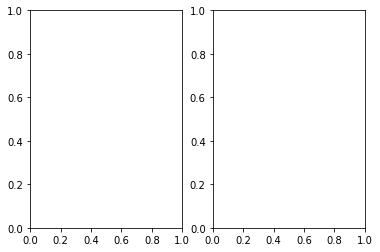

In [193]:
ppl = Pipeline([
     ('RemoveExtremes',DropOutliers('T3')),
#      ('RemoveExtremes',DropOutliers('TFI')) 
])

test_preprocessing(result_train,'T3',ppl)

/home/vajk/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


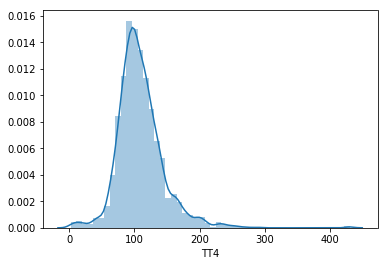

In [159]:
sns.distplot(X_train['TT4'].dropna())